# Imports

In [65]:
import random
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import sklearn.decomposition as decomposition

from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df_x = pd.read_csv('/content/drive/MyDrive/study/andan/df_main.csv', index_col=0)
df_target = pd.read_csv('/content/drive/MyDrive/study/andan/df_target.csv', index_col=0)
y_df = df_target['class']

# Functions

In [4]:
class VarianceThreshold:
    def __init__(self, threshold=None, k=10):
        self.threshold = threshold
        self.k = k

        self.feature_names = None
        self.result = None

        self.cols_info = {}

    def fit_by_threshold(self, df_x):
        all = df_x.shape[0]
        good_cols = []
        for i in df_x.columns:
            values = df_x[i].unique()
            unique_persent = []
            for val in values:
                unique_persent.append(df_x[i][df_x[i] == val].shape[0] / all)

            biggest_class = max(unique_persent)
            disp_col = biggest_class(1 - biggest_class)
            self.cols_info[i] = disp_col
            if disp_col > self.threshold:
                good_cols.append(i)

        self.feature_names = good_cols
        return self

    def fit_by_k(self, df_x):
        all = df_x.shape[0]
        for i in df_x.columns:
            values = df_x[i].unique()
            unique_persent = []
            for val in values:
                unique_persent.append(df_x[i][df_x[i] == val].shape[0] / all)

            biggest_class = max(unique_persent)
            disp_col = biggest_class * (1 - biggest_class)
            self.cols_info[i] = disp_col
        self.feature_names = sorted(self.cols_info, key=self.cols_info.get, reverse=True)[:self.k]
        return self

    def transform(self, df_x):
        self.result = df_x[self.feature_names]
        return self.result

    def fit(self, df_x):
        if self.threshold is not None:
            self.fit_by_threshold(df_x)
        else:
            self.fit_by_k(df_x)
        return self

    def fit_transform(self, df_x):
        return self.fit(df_x).transform(df_x)

In [5]:
class SFS_Linear:
    def __init__(self, k=10):
        self.k = k
        self.feature_names = []
        self.all_columns = set()
        self.x = None
        self.y = None

        self.result = pd.DataFrame()

    def fit(self, df_x , y):
        self.all_columns = set(df_x.columns)
        self.x = df_x
        self.y = y

        self.first_learning()
        while len(self.feature_names) < self.k:
            self.learning()
        return self

    def transform(self):
        return self.result

    def fit_transform(self, df_x , y):
        return self.fit(df_x , y).transform()

    def first_learning(self):
        cols_info = {}
        for i in self.all_columns:
            clf = RidgeClassifier(random_state=42).fit(self.x, self.y)
            cols_info[i] = clf.score(self.x, self.y)
        self.feature_names.extend(sorted(cols_info, key=cols_info.get, reverse=True)[:1])
        self.result = self.x[self.feature_names]

    def learning(self):
        cols_info = {}
        for i in self.all_columns - set(self.feature_names):
            between = pd.concat([self.result, self.x[i]], axis=1)
            cols_info[i] = RidgeClassifier(random_state=42).fit(between, self.y).score(between, self.y)
        self.feature_names.extend(sorted(cols_info, key=cols_info.get, reverse=True)[:1])
        self.result = self.x[self.feature_names]


In [6]:
class BuildIn_Linear:
    def __init__(self, k=10):
        self.k = k
        self.feature_names = []
        self.x = None
        self.y = None

    def fit(self, df_x , y):
        self.feature_names = df_x.columns
        self.x = df_x
        self.y = y

        step = int(np.sqrt(len(self.feature_names)))
        while len(self.feature_names) > self.k:
            if len(self.feature_names) - step < self.k:
                step = len(self.feature_names) - self.k
            self.learning(step)

        return self

    def transform(self):
        return self.x[self.feature_names]

    def fit_transform(self, df_x , y):
        return self.fit(df_x , y).transform()

    def learning(self, step):
        clf = RidgeClassifier(random_state=42).fit(self.x[self.feature_names], self.y)
        weights = abs(clf.coef_)
        cols_info = {}
        for num, name in enumerate(self.feature_names):
            cols_info[name] = weights[num]

        self.feature_names = sorted(cols_info, key=cols_info.get, reverse=True)[:len(cols_info) - step]

In [57]:
class Kmeans:
    def __init__(self, k, epoches=100, random_state=123):
        self.k = k
        self.epoches = epoches
        self.centers = None
        self.lables = None
        np.random.seed(random_state)

    def fit(self, df):
        ids = np.random.permutation(df.shape[0])
        self.centers = df[ids[:self.k]]
        for _ in range(self.epoches):
            norm_x = np.expand_dims(df, axis=1)
            dist = np.linalg.norm((norm_x - self.centers), axis=-1)
            self.lables = np.argmin(dist, axis=1)
            for i in range(self.k):
                centroid_mean = norm_x[self.lables == i].mean(
                    axis=0)
                self.centers[i] = centroid_mean
        return self

# Implements

## Filters

mine

In [8]:
selector = VarianceThreshold(k=100).fit(df_x)
df_x = selector.transform(df_x)

In [ ]:
selector = VarianceThreshold(k=30).fit(df_x)
vt_f = selector.feature_names

scikit-learn

In [ ]:
selector = SelectKBest(f_classif, k=30)
selector.fit(df_x, y_df)
X_new = selector.transform(df_x)

fc_f = list(selector.get_feature_names_out())

## Embedded


mine

In [9]:
el_f = BuildIn_Linear(k=30).fit(df_x, y_df).feature_names

scikit-learn

In [ ]:
selector = SelectFromModel(estimator=LogisticRegression(), max_features=30).fit(df_x, y_df)
sl_f = list(selector.get_feature_names_out())

## Wrapper

mine

In [ ]:
sfsl_f = SFS_Linear(k=30).fit(df_x, y_df).feature_names

scikit-learn

In [ ]:
df_target_men = df_target[df_target['class'] == 2]
df_target_women = df_target[df_target['class'] == 1]

df_target_lowest_men = df_target_men.sample(300, random_state=42)
df_target_lowest_women = df_target_women.sample(300, random_state=42)
df_x_lowest_men = df_x.loc[df_target_lowest_men.index]
df_x_lowest_women = df_x.loc[df_target_lowest_women.index]
df_x_low = pd.concat([df_x_lowest_women, df_x_lowest_men])
df_y_low = pd.concat([df_target_lowest_women, df_target_lowest_men])

df_y_low.replace({'class': {2: -1}}, inplace=True)

df_y_low = df_y_low['class'].to_numpy()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=30)
sfs = SequentialFeatureSelector(knn, n_features_to_select=30, direction='backward')
sfs.fit(df_x_low, df_y_low)
bsf_f = list(sfs.get_feature_names_out())

# Select FS

In [ ]:
all_fs_dict = {
    "bsf_f": bsf_f,
    "sfsl_f": sfsl_f,
    "sl_f":sl_f,
    "el_f":el_f,
    "fc_f": fc_f,
    "vt_f": vt_f
}
all_fs_list = [sfsl_f, sl_f, el_f, fc_f, vt_f]

In [ ]:
set.intersection(*[set(list) for list in all_fs_list])

{'грейпфрут',
 'древесные_f_g',
 'лава',
 'пряные_f_g',
 'фужерные_f_g',
 'цветочные_f_g'}

## Models

In [ ]:
def get_scores(score_dict_, x, y, name):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    sum = 0
    local_score = {}
    clf = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
    res = clf.predict(X_test)
    sum += accuracy_score(y_test, res)
    local_score["gb"] = accuracy_score(y_test, res)

    clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
    res = clf.predict(X_test)
    local_score["rf"] = accuracy_score(y_test, res)
    sum += accuracy_score(y_test, res)

    clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)
    res = clf.predict(X_test)
    local_score["ada"] = accuracy_score(y_test, res)
    sum += accuracy_score(y_test, res)

    local_score['averg'] = sum /3
    score_dict[name] = local_score

In [ ]:
score_dict = {}

for i in all_fs_dict.keys():
    get_scores(score_dict, df_x[all_fs_dict.get(i)], y_df, i)

get_scores(score_dict, df_x, y_df, "full")

In [ ]:
score_dict

{'bsf_f': {'gb': 0.8412559419564674,
  'rf': 0.8352514385789342,
  'ada': 0.8383787840880661,
  'averg': 0.8382953882078225},
 'sfsl_f': {'gb': 0.8467600700525394,
  'rf': 0.831498623967976,
  'ada': 0.8410057543157368,
  'averg': 0.8397548161120841},
 'sl_f': {'gb': 0.8506379784838629,
  'rf': 0.8408806604953716,
  'ada': 0.840630472854641,
  'averg': 0.8440497039446252},
 'el_f': {'gb': 0.852014010507881,
  'rf': 0.8436327245434075,
  'ada': 0.8451338503877909,
  'averg': 0.8469268618130265},
 'fc_f': {'gb': 0.851138353765324,
  'rf': 0.8373780335251438,
  'ada': 0.8446334751063298,
  'averg': 0.8443832874655991},
 'vt_f': {'gb': 0.8472604453340005,
  'rf': 0.8427570678008507,
  'ada': 0.8433825369026771,
  'averg': 0.8444666833458427},
 'full': {'gb': 0.8636477358018514,
  'rf': 0.8643982987240431,
  'ada': 0.8503877908431323,
  'averg': 0.8594779417896756}}

In [10]:
df_new_x = df_x[el_f]

# Clustering

внешняя - аккураси, внутренняя


внутренняя - Силуэт (англ. Silhouette)
 https://scikit-learn.ru/stable/modules/clustering.html#silhouette-coefficient


Выделенные признаки

In [71]:
model = Kmeans(2).fit(df_new_x.to_numpy())
fs_lables = model.lables

print("Accuracy:")
print(accuracy_score(y_df, fs_lables))
print("Silhouette Index:")
print(metrics.silhouette_score(df_new_x.to_numpy(), fs_lables, metric='euclidean'))

Accuracy:
0.19170576093075625
Silhouette Index:
0.4126847704503432


Все признаки

In [72]:
model = Kmeans(2).fit(df_x.to_numpy())
full_lables = model.lables

print("Accuracy:")
print(accuracy_score(y_df, full_lables))
print("Silhouette Index:")
print(metrics.silhouette_score(df_x.to_numpy(), full_lables, metric='euclidean'))

Accuracy:
0.35834115218615126
Silhouette Index:
0.08330637410279923


Все признаки

# PCA TSNE

До

In [69]:
pca = decomposition.PCA(n_components=2)
scaled_data = df_x
data_pca = pca.fit_transform(scaled_data)
pca_df_full = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
pca_df_full['real'] = y_df
pca_df_full['clust'] = full_lables

embedding = TSNE(n_components=2)
x_embed = embedding.fit_transform(df_x)
embded = pd.DataFrame(x_embed)

tsne_df_full = pd.DataFrame()
tsne_df_full['tsne-2d'] = embded[0]
tsne_df_full['tsne-2d-two'] = embded[1]
tsne_df_full['real'] = y_df
tsne_df_full['clust'] = full_lables

После

In [74]:
pca = decomposition.PCA(n_components=2)
scaled_data = df_new_x
data_pca = pca.fit_transform(scaled_data)
pca_df_fs = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
pca_df_fs['real'] = y_df
pca_df_fs['clust'] = fs_lables

embedding = TSNE(n_components=2)
x_embed = embedding.fit_transform(df_new_x)
embded = pd.DataFrame(x_embed)

tsne_df_fs = pd.DataFrame()
tsne_df_fs['tsne-2d'] = embded[0]
tsne_df_fs['tsne-2d-two'] = embded[1]
tsne_df_fs['real'] = y_df
tsne_df_fs['clust'] = fs_lables

## PLots

Full Data

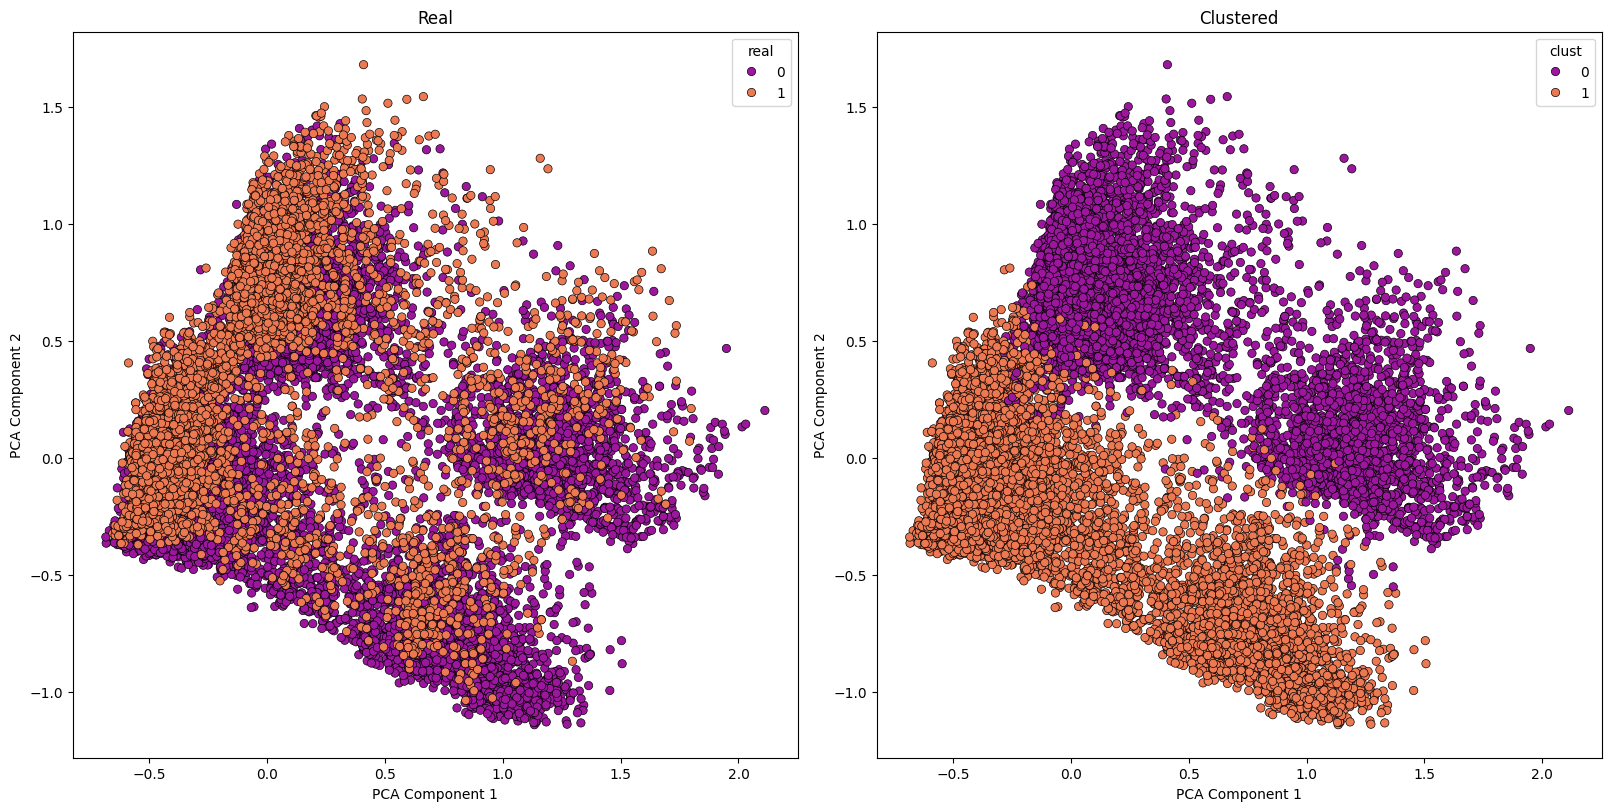

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
sns.scatterplot(data=pca_df_full, x='PCA1', y='PCA2', hue=pca_df_full['real'], palette='plasma', edgecolor='black', ax=ax1)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title('Real')

sns.scatterplot(data=pca_df_full, x='PCA1', y='PCA2', hue=pca_df_full['clust'], palette='plasma', edgecolor='black', ax=ax2)
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_title('Clustered')

plt.show()

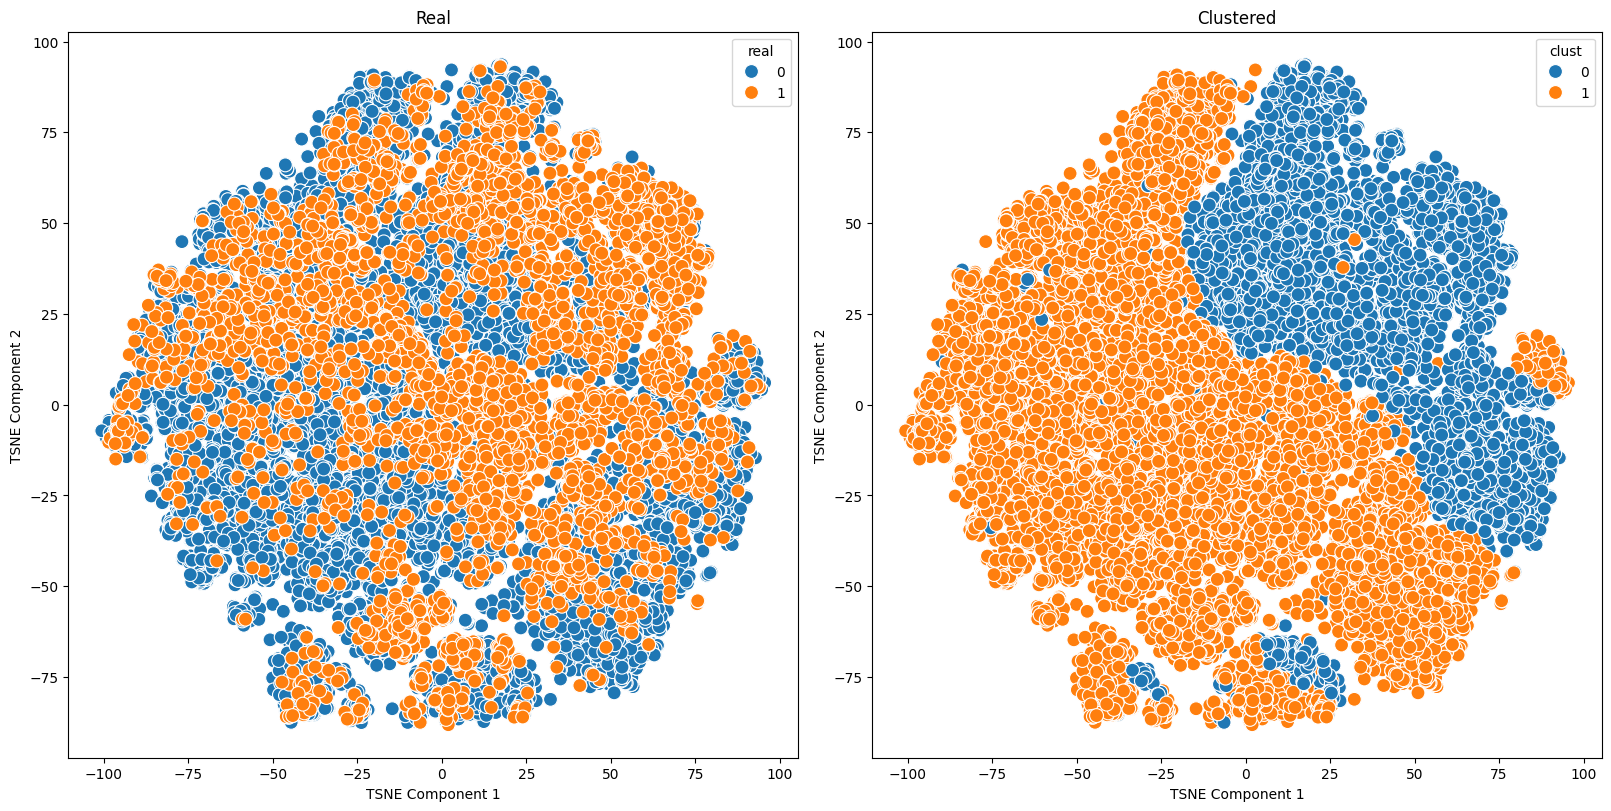

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
sns.scatterplot(x="tsne-2d", y="tsne-2d-two", hue="real", data=tsne_df_full,
    legend="full", s=100, alpha=1, ax=ax1)
ax1.set_xlabel('TSNE Component 1')
ax1.set_ylabel('TSNE Component 2')
ax1.set_title('Real')

sns.scatterplot(x="tsne-2d", y="tsne-2d-two", hue="clust", data=tsne_df_full,
    legend="full", s=100, alpha=1, ax=ax2)
ax2.set_xlabel('TSNE Component 1')
ax2.set_ylabel('TSNE Component 2')
ax2.set_title('Clustered')

plt.show()

FS-ed

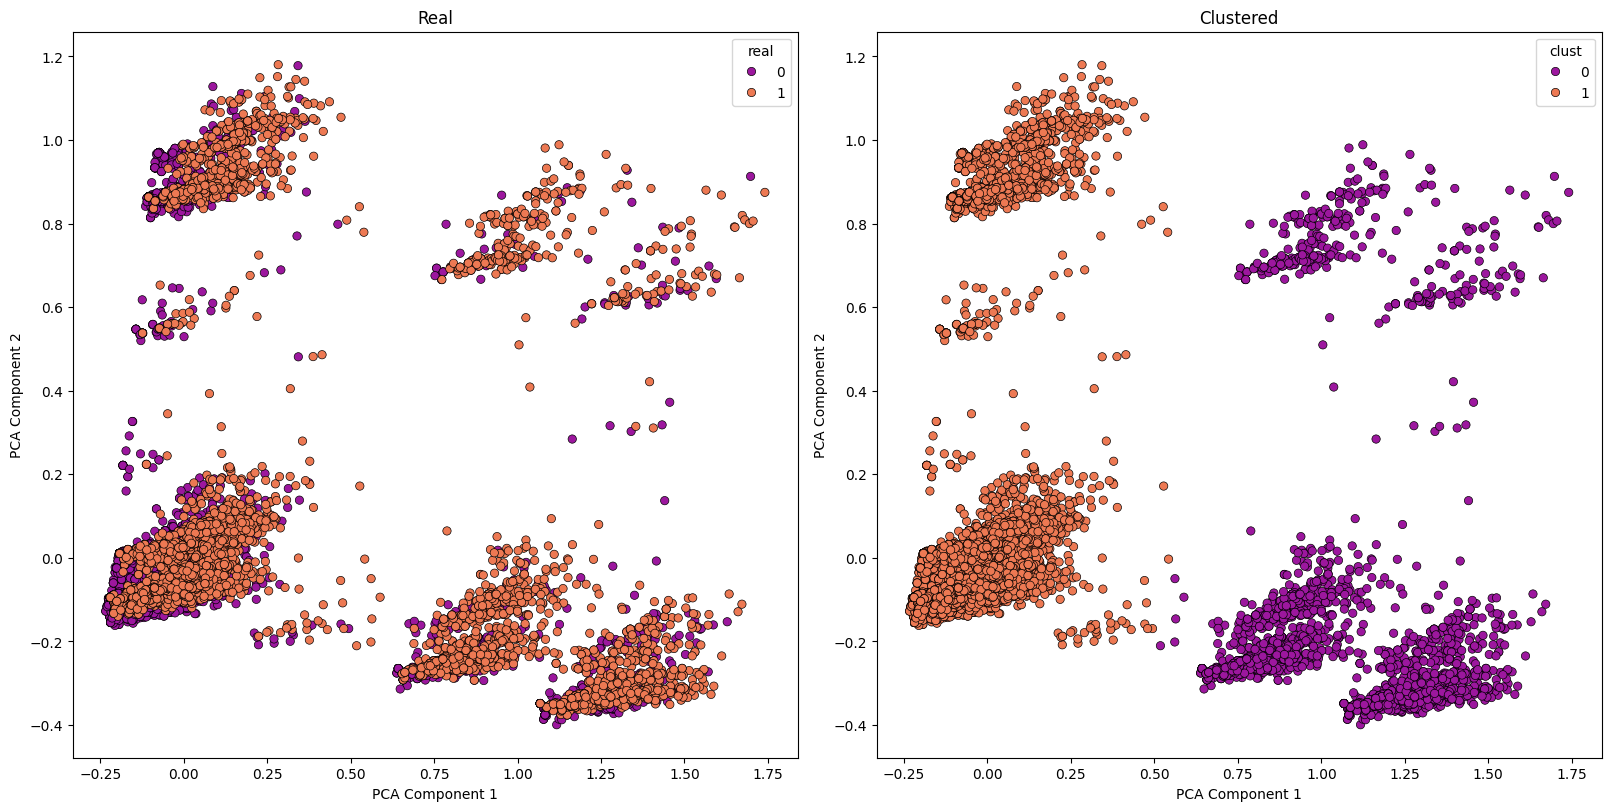

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
sns.scatterplot(data=pca_df_fs, x='PCA1', y='PCA2', hue=pca_df_fs['real'], palette='plasma', edgecolor='black', ax=ax1)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title('Real')

sns.scatterplot(data=pca_df_fs, x='PCA1', y='PCA2', hue=pca_df_fs['clust'], palette='plasma', edgecolor='black', ax=ax2)
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_title('Clustered')

plt.show()

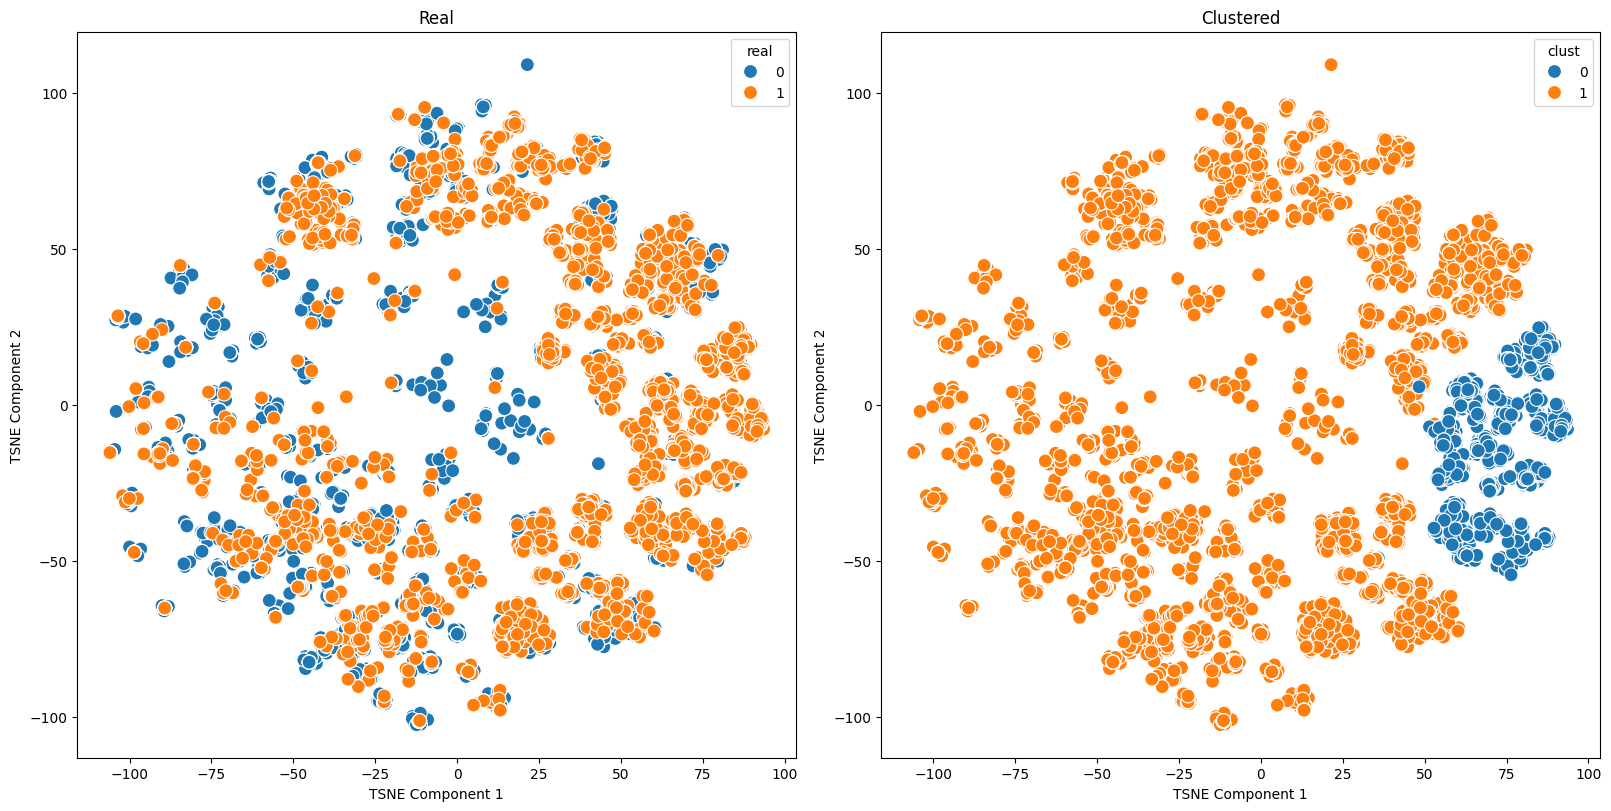

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
sns.scatterplot(x="tsne-2d", y="tsne-2d-two", hue="real", data=tsne_df_fs,
    legend="full", s=100, alpha=1, ax=ax1)
ax1.set_xlabel('TSNE Component 1')
ax1.set_ylabel('TSNE Component 2')
ax1.set_title('Real')

sns.scatterplot(x="tsne-2d", y="tsne-2d-two", hue="clust", data=tsne_df_fs,
    legend="full", s=100, alpha=1, ax=ax2)
ax2.set_xlabel('TSNE Component 1')
ax2.set_ylabel('TSNE Component 2')
ax2.set_title('Clustered')

plt.show()